In [1]:
import pandas as pd
import geopandas as gpd
import zipfile
import requests
import io

/Users/z/code/data-visualization/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


# Census Data

In [14]:
geography_type = "SSC"
geography_type = "SA1"
au_state = "NSW"
census_metric = "Median_tot_fam_inc_weekly"
zoom_radius_center ="Sydney GPO"
zoom_radius_meters = 30000

shapes_url = f"https://www.censusdata.abs.gov.au/CensusOutput/copsubdatapacks.nsf/All%20docs%20by%20catNo/Boundaries_2016_{geography_type}/$File/2016_{geography_type}_shape.zip"
data_url = f"https://www.censusdata.abs.gov.au/CensusOutput/copsubdatapacks.nsf/All%20docs%20by%20catNo/2016_GCP_{geography_type}_for_{au_state}/$File/2016_GCP_{geography_type}_for_{au_state}_short-header.zip"

geography_type_fields = { 
    "SA1": { "geo_key": "SA1_7DIGIT", "data_key": "SA1_7DIGITCODE_2016" },
    "SA2": { "geo_key": "SA2_7DIGIT", "data_key": "SA2_7DIGITCODE_2016" },
    "SA3": { "geo_key": "SA3_7DIGIT", "data_key": "SA3_7DIGITCODE_2016" },
    "SA4": { "geo_key": "SA4_CODE", "data_key": "SA4_CODE_2016" },
    "SSC": { "geo_key": "SSC_CODE", "data_key": "SSC_CODE_2016" },
}
geo_key = geography_type_fields[geography_type]["geo_key"]
data_key = geography_type_fields[geography_type]["data_key"]

# Load geographical shapes for statistical areas

In [3]:
shapes_gpd = gpd.read_file(shapes_url)

In [4]:
shapes_gpd

,SA1_7DIGIT,SA1_MAIN16,STATE_CODE,STATE_NAME,AREA_SQKM,geometry
0,1100701,10102100701,1,New South Wales,362.8727,"POLYGON ((149.76065 -35.08348, 149.76795 -35.0..."
1,1100702,10102100702,1,New South Wales,229.7459,"POLYGON ((149.71072 -35.36429, 149.71237 -35.3..."
2,1100703,10102100703,1,New South Wales,2.3910,"POLYGON ((149.79653 -35.44562, 149.79608 -35.4..."
3,1100704,10102100704,1,New South Wales,1.2816,"POLYGON ((149.79882 -35.43074, 149.80607 -35.4..."
4,1100705,10102100705,1,New South Wales,1.1978,"POLYGON ((149.78674 -35.44490, 149.79080 -35.4..."
...,...,...,...,...,...,...
57518,9100406,90104100406,9,Other Territories,4.9544,"MULTIPOLYGON (((167.94846 -29.00356, 167.94842..."
57519,9100407,90104100407,9,Other Territories,10.5956,"MULTIPOLYGON (((167.92006 -29.04313, 167.91988..."
57520,9100408,90104100408,9,Other Territories,2.3801,"MULTIPOLYGON (((167.96327 -29.07217, 167.96322..."
57521,9979993,99797979993,9,Other Territories,0.0000,None


<AxesSubplot:>

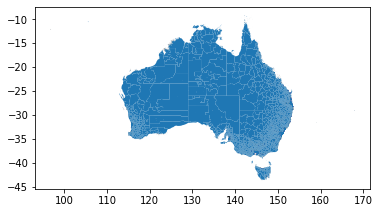

In [5]:
shapes_gpd.plot()

<AxesSubplot:>

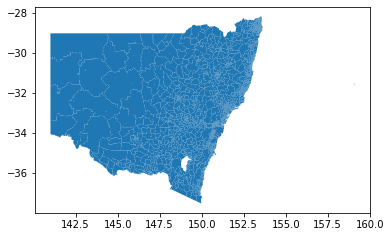

In [6]:
shapes_gpd[shapes_gpd.STATE_NAME == "New South Wales"].plot()

# Load census data

In [7]:
response = requests.get(data_url)
data_zipfile = zipfile.ZipFile(io.BytesIO(response.content))

In [8]:
import re
nsw_ssc_df = shapes_gpd.rename(columns={geo_key: data_key})
for zipinfo in data_zipfile.filelist:
    if re.match(r".*2016Census_G02", zipinfo.filename):
        print(zipinfo.filename)
        census_data_df = pd.read_csv(data_zipfile.open(zipinfo.filename), dtype={data_key: 'str'})
        print(nsw_ssc_df.columns)
        census_df = pd.merge(nsw_ssc_df, census_data_df)
        
census_gdf = gpd.GeoDataFrame(census_df, geometry=nsw_ssc_df.geometry)
census_gdf

2016 Census GCP Statistical Area 1 for NSW/2016Census_G02_NSW_SA1.csv
Index(['SA1_7DIGITCODE_2016', 'SA1_MAIN16', 'STATE_CODE', 'STATE_NAME',
       'AREA_SQKM', 'geometry'],
      dtype='object')


,SA1_7DIGITCODE_2016,SA1_MAIN16,STATE_CODE,STATE_NAME,AREA_SQKM,geometry,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size
0,1100701,10102100701,1,New South Wales,362.8727,"POLYGON ((149.76065 -35.08348, 149.76795 -35.0...",50,1185,483,0,1406,0.7,929,2.1
1,1100702,10102100702,1,New South Wales,229.7459,"POLYGON ((149.71072 -35.36429, 149.71237 -35.3...",51,1798,671,123,1902,0.7,1636,2.5
2,1100703,10102100703,1,New South Wales,2.3910,"POLYGON ((149.79653 -35.44562, 149.79608 -35.4...",42,1350,634,270,1375,0.7,1044,2.3
3,1100704,10102100704,1,New South Wales,1.2816,"POLYGON ((149.79882 -35.43074, 149.80607 -35.4...",49,1647,514,280,1375,0.8,1021,2.2
4,1100705,10102100705,1,New South Wales,1.1978,"POLYGON ((149.78674 -35.44490, 149.79080 -35.4...",45,1733,602,293,1375,0.7,1045,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18394,1160910,12802160910,1,New South Wales,0.1315,"POLYGON ((151.02666 -34.03209, 151.02651 -34.0...",37,2600,906,530,2890,0.9,2963,3.3
18395,1979991,19797979991,1,New South Wales,0.0000,None,0,0,0,0,0,0.0,0,0.0
18396,1979992,19797979992,1,New South Wales,0.0000,None,21,0,0,0,0,0.0,0,0.0
18397,1979993,19797979993,1,New South Wales,0.0000,None,59,0,544,0,0,0.0,0,0.0


In [9]:
for column in census_gdf.columns:
    print(column)

SA1_7DIGITCODE_2016
SA1_MAIN16
STATE_CODE
STATE_NAME
AREA_SQKM
geometry
Median_age_persons
Median_mortgage_repay_monthly
Median_tot_prsnl_inc_weekly
Median_rent_weekly
Median_tot_fam_inc_weekly
Average_num_psns_per_bedroom
Median_tot_hhd_inc_weekly
Average_household_size


<AxesSubplot:>

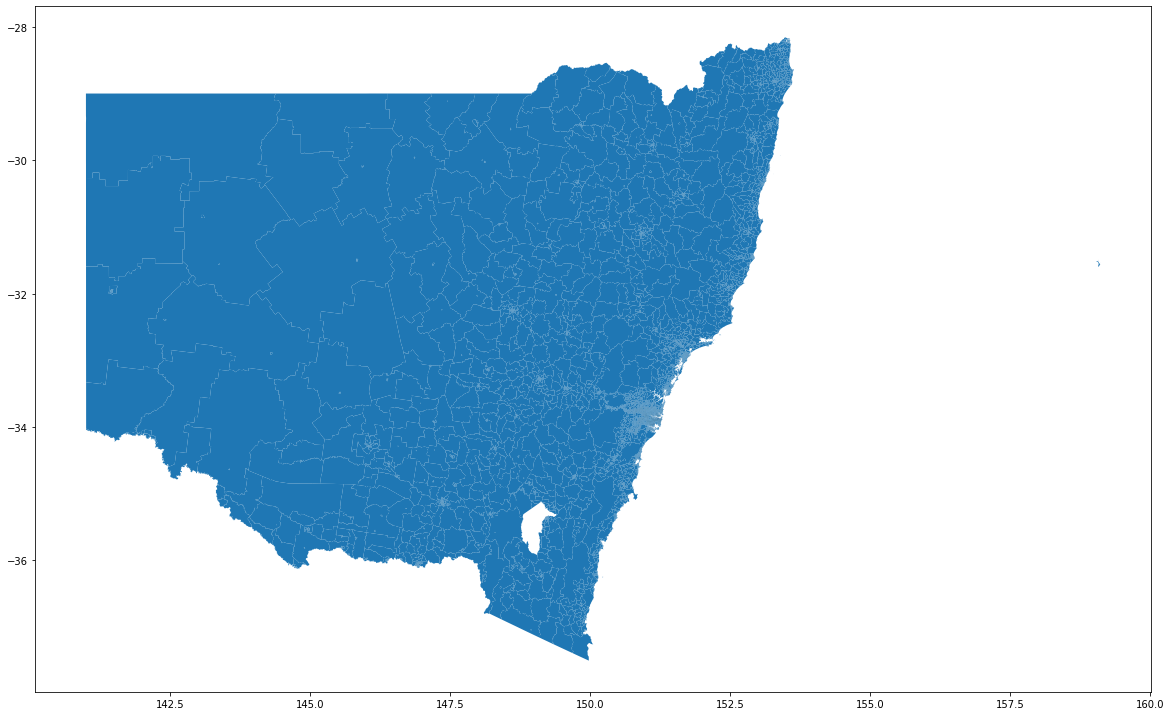

In [10]:
census_gdf.plot(figsize=(20,15))

<AxesSubplot:>

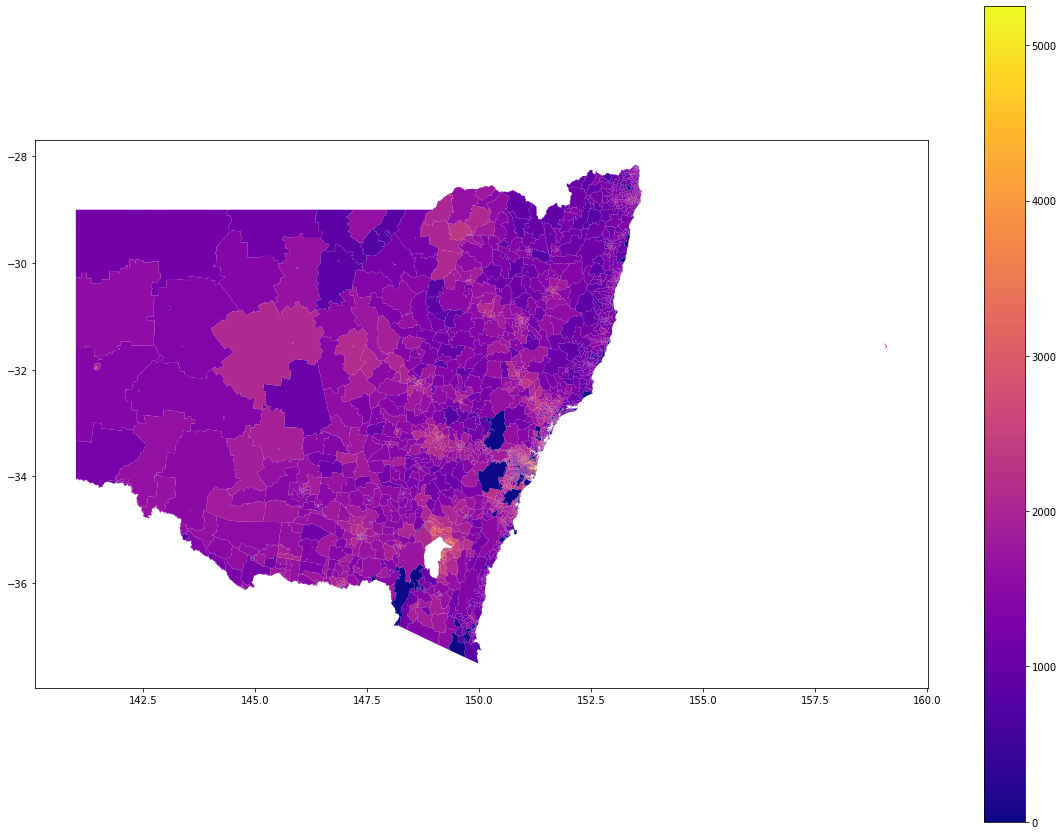

In [11]:
census_gdf.plot(census_metric, legend=True, figsize=(20,15), cmap="plasma")

# Zoom to selected area

<AxesSubplot:>

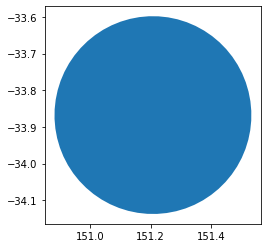

In [16]:
sydney_gpo_df = gpd.tools.geocode([zoom_radius_center], provider='nominatim', user_agent="maksym demo")
sydney_gpo_radius_df = sydney_gpo_df.to_crs(epsg=20255).buffer(zoom_radius_meters).to_crs(epsg=4283)
sydney_gpo_radius_df.plot()

<AxesSubplot:>

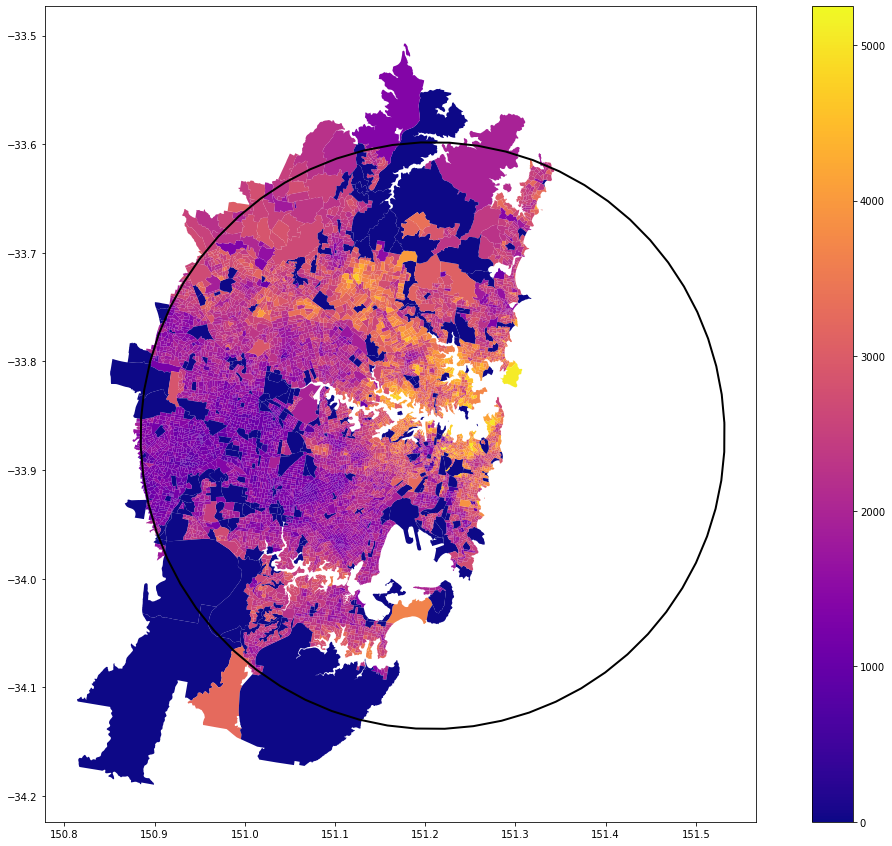

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20,15))


census_gdf[census_gdf.geometry.intersects(sydney_gpo_radius_df.iloc[0])].plot(census_metric, ax=ax, legend=True, figsize=(20,15), cmap="plasma")
sydney_gpo_radius_df.plot(ax=ax, color="#00000000", edgecolor="black", linewidth=2)